In [55]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL as pil
import os

**HPARAMS**

In [56]:
BATCH_SIZE = 1024

In [57]:
IMG_SIZE = (64, 64)

**Load Data**

In [58]:
DATA_DIR = "dataset"

In [59]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 24705 files belonging to 2 classes.
Using 19764 files for training.


In [60]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 24705 files belonging to 2 classes.
Using 4941 files for validation.


In [61]:
class_names = train_ds.class_names
print(class_names)

['organic', 'recyclable']


**Visualize Data**

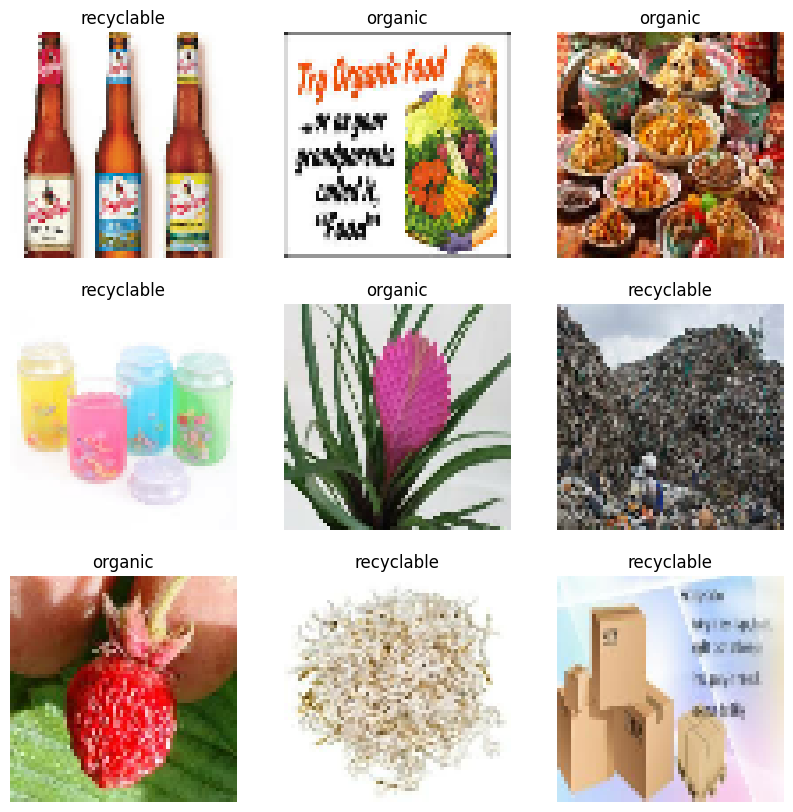

In [62]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [63]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(1024, 64, 64, 3)
(1024,)


**Preprocess Data**

In [64]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)

In [65]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9982597


In [66]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Utilitary**

In [67]:
def path_exists(path: str) -> str:
    if os.path.exists(path):
        i = 0
        while True:
            new_path = f"{path}_{i}"
            if not os.path.exists(new_path):
                return new_path
            i += 1
    return path

**Model**

In [68]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(64, 64, 3)))

# Conv & pooling tf.keras.layers
model.add(tf.keras.layers.Conv2D(4, (3, 3), activation='tanh', padding='same'))
model.add(tf.keras.layers.Conv2D(4, (3, 3), activation='tanh', padding='same'))
model.add(tf.keras.layers.MaxPool2D())

# Fully connected tf.keras.layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [69]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])

In [70]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 4)         112       
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 4)         148       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 4)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4096)              0         
                                                                 
 dense_4 (Dense)             (None, 8)                 32776     
                                                                 
 dense_5 (Dense)             (None, 2)                 18        
                                                      

In [71]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=10,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
                     tf.keras.callbacks.TensorBoard(log_dir=f"{path_exists('tensorlogs/logs')}")])
loss, accuracy = model.evaluate(val_ds)
model.save(f"models/model_loss_{loss}_acc_{accuracy}.h5")

Epoch 1/10
20/20 [==============================] - 16s 681ms/step - loss: 0.6397 - accuracy: 0.6816 - val_loss: 0.5071 - val_accuracy: 0.7683
Epoch 2/10
20/20 [==============================] - 10s 517ms/step - loss: 0.4988 - accuracy: 0.7717 - val_loss: 0.4687 - val_accuracy: 0.7845
Epoch 3/10
20/20 [==============================] - 10s 501ms/step - loss: 0.4539 - accuracy: 0.7856 - val_loss: 0.4470 - val_accuracy: 0.7921
Epoch 4/10
20/20 [==============================] - 10s 511ms/step - loss: 0.4428 - accuracy: 0.7955 - val_loss: 0.4348 - val_accuracy: 0.8031
Epoch 5/10
20/20 [==============================] - 10s 520ms/step - loss: 0.4313 - accuracy: 0.8014 - val_loss: 0.4249 - val_accuracy: 0.8047
Epoch 6/10
20/20 [==============================] - 10s 524ms/step - loss: 0.4273 - accuracy: 0.8051 - val_loss: 0.4305 - val_accuracy: 0.8011
Epoch 7/10
20/20 [==============================] - 10s 521ms/step - loss: 0.4260 - accuracy: 0.8070 - val_loss: 0.4214 - val_accuracy: 0.8063

**Testing Model**

In [72]:
model = tf.keras.models.load_model("models/model_loss_0.41599953174591064_acc_0.8107670545578003.h5")

In [78]:
img = pil.Image.open("testing/briatte.png").resize(IMG_SIZE)
img = np.array(img)

In [79]:
predictions = model.predict(img[None, :, :]).argmax(axis=1)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_2/conv2d_4/BiasAdd' defined at (most recent call last):
    File "C:\Users\arman\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\arman\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\arman\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Users\arman\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Users\arman\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\arman\AppData\Local\Temp\ipykernel_20148\2880090747.py", line 1, in <module>
      predictions = model.predict(img[None, :, :]).argmax(axis=1)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\arman\Desktop\4AL\Hackaton_AL_AI\venv\lib\site-packages\keras\layers\convolutional\base_conv.py", line 304, in call
      outputs = tf.nn.bias_add(
Node: 'sequential_2/conv2d_4/BiasAdd'
input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node sequential_2/conv2d_4/BiasAdd}}]] [Op:__inference_predict_function_10041]

In [75]:
predictions

array([1], dtype=int64)